In [3]:
# Recurrent Neural Network

# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Importing the training set
dataset= pd.read_csv("Datasets/covid_stocks_with_covid_data.csv")

In [4]:
dataset.head()

,pandemic_date,daily_new_cases,daily_new_deaths,stock_ticker,open_price,highest,lowest,closing,Trading_Volume,Volume_Weighted_Average_Price,Number_of_Transactions
0,2020-03-11,307.0,8.0,PFE,30.48,32.000,30.00,30.02,60585686.0,30.6586,307447.0
1,2020-03-12,1174.0,4.0,PFE,31.27,32.880,30.23,32.71,58156515.0,31.4335,313654.0
2,2020-03-15,1046.0,17.0,PFE,29.94,32.285,29.65,30.18,48333517.0,30.9841,270185.0
3,2020-03-16,1336.0,21.0,PFE,31.64,32.650,30.59,32.16,52139745.0,31.6114,317412.0
4,2020-03-17,2442.0,25.0,PFE,30.77,32.610,30.31,32.36,42228311.0,31.6159,249462.0


In [5]:
dataset['pandemic_date'] =  pd.to_datetime(dataset['pandemic_date'], infer_datetime_format=True)

In [6]:
dataset_train = dataset[dataset["pandemic_date"].isin(pd.date_range("2020-03-11", "2020-12-30"))]
dataset_train_m = dataset_train[dataset_train['stock_ticker']=='MRNA']
dataset_train_m

,pandemic_date,daily_new_cases,daily_new_deaths,stock_ticker,open_price,highest,lowest,closing,Trading_Volume,Volume_Weighted_Average_Price,Number_of_Transactions
1371,2020-03-11,307.0,8.0,MRNA,22.8997,24.2800,21.9000,22.30,11305347.0,22.9997,70915.0
1372,2020-03-12,1174.0,4.0,MRNA,23.0000,23.4700,19.3100,21.30,11853052.0,21.0470,82944.0
1373,2020-03-15,1046.0,17.0,MRNA,23.7600,27.8000,22.2200,26.49,39850785.0,25.7404,249726.0
1374,2020-03-16,1336.0,21.0,MRNA,29.3600,32.7000,27.3148,28.18,44484144.0,29.9634,282956.0
1375,2020-03-17,2442.0,25.0,MRNA,27.1300,32.5400,26.5500,31.58,28702290.0,30.7496,201241.0
...,...,...,...,...,...,...,...,...,...,...,...
17534,2020-12-23,232340.0,3411.0,MRNA,125.9400,129.7000,122.7201,123.39,12720588.0,124.9976,124137.0
17535,2020-12-27,150278.0,1584.0,MRNA,120.0400,122.8800,111.0500,111.40,31088166.0,115.5921,332671.0
17536,2020-12-28,185422.0,2374.0,MRNA,107.7957,116.2500,106.8800,114.39,23718799.0,113.2451,227932.0
17537,2020-12-29,207215.0,3801.0,MRNA,118.4000,118.9408,108.8000,111.13,23965535.0,112.4531,221173.0


In [11]:
training_set = dataset_train_m.iloc[:, [1,2,7]].values
training_set

array([[3.07000e+02, 8.00000e+00, 2.23000e+01],
       [1.17400e+03, 4.00000e+00, 2.13000e+01],
       [1.04600e+03, 1.70000e+01, 2.64900e+01],
       ...,
       [1.85422e+05, 2.37400e+03, 1.14390e+02],
       [2.07215e+05, 3.80100e+03, 1.11130e+02],
       [2.33120e+05, 4.10000e+03, 1.04470e+02]])

In [12]:
# Feature Scaling
# Use Normalization (versus Standardization) for RNNs with Sigmoid Activation Functions
# 'MinMaxScalar' is a Normalization Library
from sklearn.preprocessing import MinMaxScaler
# 'feature_range = (0,1)' makes sure that training data is scaled to have values between 0 and 1
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.00000000e+00, 9.76562500e-04, 6.73128702e-03],
       [3.43064711e-03, 0.00000000e+00, 0.00000000e+00],
       [2.92416173e-03, 3.17382812e-03, 3.49353796e-02],
       ...,
       [7.32484707e-01, 5.78613281e-01, 6.26615509e-01],
       [8.18717801e-01, 9.27001953e-01, 6.04671513e-01],
       [9.21221738e-01, 1.00000000e+00, 5.59841142e-01]])

In [236]:
training_set_scaled.shape

(1640, 3)

In [222]:
# Creating a data structure with 60 timesteps (look back 60 days) and 1 output
# This tells the RNN what to remember (Number of timesteps) when predicting the next Stock Price
# The wrong number of timesteps can lead to Overfitting or bogus results
# 'x_train' Input with 60 previous days' stock prices
X_train = []
#X_train=training_set_scaled
# 'y_train' Output with next day's stock price
y_train = []
for i in range(60, 1640):
    X_train.append(training_set_scaled[i-60:i,])
    y_train.append(training_set_scaled[i,2])
    
#y_train=dataset_tarin_m.iloc[:, [7]].values
X_train, y_train = np.array(X_train), np.array(y_train)

In [223]:
X_train

array([[[0.        , 0.00097656, 0.00673129],
        [0.00343065, 0.        , 0.        ],
        [0.00292416, 0.00317383, 0.03493538],
        ...,
        [0.09243754, 0.28051758, 0.25976037],
        [0.0845791 , 0.27124023, 0.26447227],
        [0.09206955, 0.25341797, 0.24831718]],

       [[0.00343065, 0.        , 0.        ],
        [0.00292416, 0.00317383, 0.03493538],
        [0.00407167, 0.00415039, 0.04631125],
        ...,
        [0.0845791 , 0.27124023, 0.26447227],
        [0.09206955, 0.25341797, 0.24831718],
        [0.07503106, 0.10742188, 0.25444265]],

       [[0.00292416, 0.00317383, 0.03493538],
        [0.00407167, 0.00415039, 0.04631125],
        [0.00844802, 0.00512695, 0.06919763],
        ...,
        [0.09206955, 0.25341797, 0.24831718],
        [0.07503106, 0.10742188, 0.25444265],
        [0.07264108, 0.16113281, 0.24858643]],

       ...,

       [[0.18723736, 0.20361328, 0.31980345],
        [0.13343911, 0.10229492, 0.34093969],
        [0.15820546, 0

In [224]:
X_train.shape

(1580, 60, 3)

In [15]:
y_train

array([0.25444265, 0.24858643, 0.260972  , ..., 0.62661551, 0.60467151,
       0.55984114])

In [16]:
y_train=y_train.reshape((-1,1))
y_train

array([[0.25444265],
       [0.24858643],
       [0.260972  ],
       ...,
       [0.62661551],
       [0.60467151],
       [0.55984114]])

In [17]:
# Reshaping (add more dimensions)
# This lets you add more indicators that may potentially have corelation with Stock Prices
# Keras RNNs expects an input shape (Batch Size, Timesteps, input_dim)
# '.shape[0]' is the number of Rows (Batch Size)
# '.shape[1]' is the number of Columns (timesteps)
# 'input_dim' is the number of factors that may affect stock prices
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 3))

# Show the dataset we're working with
display(X_train)

array([[[0.        , 0.00097656, 0.00673129],
        [0.00343065, 0.        , 0.        ],
        [0.00292416, 0.00317383, 0.03493538],
        ...,
        [0.09243754, 0.28051758, 0.25976037],
        [0.0845791 , 0.27124023, 0.26447227],
        [0.09206955, 0.25341797, 0.24831718]],

       [[0.00343065, 0.        , 0.        ],
        [0.00292416, 0.00317383, 0.03493538],
        [0.00407167, 0.00415039, 0.04631125],
        ...,
        [0.0845791 , 0.27124023, 0.26447227],
        [0.09206955, 0.25341797, 0.24831718],
        [0.07503106, 0.10742188, 0.25444265]],

       [[0.00292416, 0.00317383, 0.03493538],
        [0.00407167, 0.00415039, 0.04631125],
        [0.00844802, 0.00512695, 0.06919763],
        ...,
        [0.09206955, 0.25341797, 0.24831718],
        [0.07503106, 0.10742188, 0.25444265],
        [0.07264108, 0.16113281, 0.24858643]],

       ...,

       [[0.18723736, 0.20361328, 0.31980345],
        [0.13343911, 0.10229492, 0.34093969],
        [0.15820546, 0

In [88]:
X_train.shape

(1580, 60, 3)

In [20]:
# Part 2 - Building the RNN
# Building a robust stacked LSTM with dropout regularization

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [21]:
# Initialising the RNN
# Regression is when you predict a continuous value
regressor = Sequential()

2022-02-02 15:47:38.949283: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
# Adding the first LSTM layer and some Dropout regularisation
# 'units' is the number of LSTM Memory Cells (Neurons) for higher dimensionality
# 'return_sequences = True' because we will add more stacked LSTM Layers
# 'input_shape' of x_train
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 3)))
# 20% of Neurons will be ignored (10 out of 50 Neurons) to prevent Overfitting
regressor.add(Dropout(0.2))

In [24]:
# Adding a second LSTM layer and some Dropout regularisation
# Not need to specify input_shape for second Layer, it knows that we have 50 Neurons from the previous layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
# This is the last LSTM Layer. 'return_sequences = false' by default so we leave it out.
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [25]:
# Adding the output layer
# 'units = 1' because Output layer has one dimension
regressor.add(Dense(units = 3))

# Compiling the RNN
# Keras documentation recommends 'RMSprop' as a good optimizer for RNNs
# Trial and error suggests that 'adam' optimizer is a good choice
# loss = 'mean_squared_error' which is good for Regression vs. 'Binary Cross Entropy' previously used for Classification
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
# 'X_train' Independent variables
# 'y_train' Output Truths that we compare X_train to.
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
50/50 [==============================] - 16s 105ms/step - loss: 0.0414
Epoch 2/100
50/50 [==============================] - 4s 89ms/step - loss: 0.0096
Epoch 3/100
50/50 [==============================] - 4s 85ms/step - loss: 0.0071
Epoch 4/100
50/50 [==============================] - 4s 89ms/step - loss: 0.0078
Epoch 5/100
50/50 [==============================] - 4s 89ms/step - loss: 0.0058
Epoch 6/100
50/50 [==============================] - 4s 89ms/step - loss: 0.0067
Epoch 7/100
50/50 [==============================] - 4s 87ms/step - loss: 0.0062
Epoch 8/100
50/50 [==============================] - 4s 86ms/step - loss: 0.0053
Epoch 9/100
50/50 [==============================] - 4s 88ms/step - loss: 0.0058
Epoch 10/100
50/50 [==============================] - 4s 88ms/step - loss: 0.0045
Epoch 11/100
50/50 [==============================] - 4s 85ms/step - loss: 0.0050
Epoch 12/100
50/50 [==============================] - 4s 87ms/step - loss: 0.0050
Epoch 13/100
50/50 [===

50/50 [==============================] - 4s 74ms/step - loss: 0.0018


In [172]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2021

dataset_test = dataset[dataset["pandemic_date"].isin(pd.date_range("2021-01-01", "2021-12-30"))]
dataset_test_m = dataset_test[dataset_test['stock_ticker']=='MRNA']

test_set = dataset_test_m.iloc[:, [1,2,7]].values
test_set

array([[2.07829e+05, 1.62400e+03, 1.11730e+02],
       [1.98975e+05, 2.12400e+03, 1.09180e+02],
       [2.40113e+05, 3.78200e+03, 1.16260e+02],
       ...,
       [3.42971e+05, 2.06000e+03, 2.47880e+02],
       [4.83137e+05, 1.99100e+03, 2.51600e+02],
       [5.99380e+05, 1.67200e+03, 2.53980e+02]])

In [195]:
# Getting the predicted stock price of 2017
# We need 60 previous inputs for each day of the Test_set in 2017
# Combine 'dataset_train' and 'dataset_test'

# 'axis = 0' for Vertical Concatenation to add rows to the bottom


In [255]:
# Extract Stock Prices for Test time period, plus 60 days previous
#inputs = test_set[len(test_set) - 60:].values
inputs = test_set
inputs

array([[2.07829e+05, 1.62400e+03, 1.11730e+02],
       [1.98975e+05, 2.12400e+03, 1.09180e+02],
       [2.40113e+05, 3.78200e+03, 1.16260e+02],
       ...,
       [3.42971e+05, 2.06000e+03, 2.47880e+02],
       [4.83137e+05, 1.99100e+03, 2.51600e+02],
       [5.99380e+05, 1.67200e+03, 2.53980e+02]])

In [256]:
inputs = sc.transform(inputs)
inputs

array([[0.3375332 , 0.34428139, 0.00679475],
       [0.32255308, 0.46075006, 0.        ],
       [0.39215464, 0.84696017, 0.01886541],
       ...,
       [0.56618053, 0.44584207, 0.36958086],
       [0.80332798, 0.42976939, 0.37949319],
       [1.        , 0.35546238, 0.38583495]])

In [257]:
inputs.shape

(1340, 3)

In [398]:
# The following is pasted from above and modified for Testing, romove all 'Ys'
X_test = []

for i in range(60, 120):
    X_test.append(inputs[i-60:i, ])

X_test

[array([[0.3375332 , 0.34428139, 0.00679475],
        [0.32255308, 0.46075006, 0.        ],
        [0.39215464, 0.84696017, 0.01886541],
        [0.43285678, 0.92592593, 0.01574782],
        [0.46164284, 0.96762171, 0.00951264],
        [0.35565011, 0.47169811, 0.02153002],
        [0.3544404 , 0.5152574 , 0.04095499],
        [0.37802216, 0.99580713, 0.03964934],
        [0.39007867, 0.95574191, 0.05473101],
        [0.37957872, 0.96156534, 0.05454449],
        [0.24042298, 0.37153506, 0.04218071],
        [0.28399797, 0.6568833 , 0.04252711],
        [0.31067761, 0.96599115, 0.06341762],
        [0.31672447, 1.        , 0.058195  ],
        [0.22561374, 0.43885395, 0.1007754 ],
        [0.23708316, 0.47006755, 0.11391191],
        [0.2500939 , 0.88655952, 0.12403741],
        [0.25418662, 0.99254601, 0.13421621],
        [0.26966923, 0.90868856, 0.17048149],
        [0.17571441, 0.39622642, 0.12870047],
        [0.20058709, 0.51502446, 0.13163154],
        [0.18476609, 0.79361752, 0

In [399]:
X_test = np.array(X_test)

In [400]:
X_test.shape

(60, 60, 3)

In [401]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 3))
X_test

array([[[0.3375332 , 0.34428139, 0.00679475],
        [0.32255308, 0.46075006, 0.        ],
        [0.39215464, 0.84696017, 0.01886541],
        ...,
        [0.10021656, 0.24505008, 0.06421701],
        [0.0765722 , 0.09573725, 0.03794399],
        [0.08249048, 0.12508735, 0.02480748]],

       [[0.32255308, 0.46075006, 0.        ],
        [0.39215464, 0.84696017, 0.01886541],
        [0.43285678, 0.92592593, 0.01574782],
        ...,
        [0.0765722 , 0.09573725, 0.03794399],
        [0.08249048, 0.12508735, 0.02480748],
        [0.09574824, 0.16398789, 0.05800847]],

       [[0.39215464, 0.84696017, 0.01886541],
        [0.43285678, 0.92592593, 0.01574782],
        [0.46164284, 0.96762171, 0.00951264],
        ...,
        [0.08249048, 0.12508735, 0.02480748],
        [0.09574824, 0.16398789, 0.05800847],
        [0.10550038, 0.21406942, 0.06227184]],

       ...,

       [[0.10021656, 0.24505008, 0.06421701],
        [0.0765722 , 0.09573725, 0.03794399],
        [0.08249048, 0

In [402]:
X_test.shape

(60, 60, 3)

In [403]:
# Predict the Stock Price
predicted_stock_price = regressor.predict(X_test)

In [404]:
# We need to inverse the scaling of our prediction to get a Dollar amount
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price

array([[2.51433656e+05, 1.91672375e+03, 2.64298950e+02],
       [2.68776656e+05, 2.04076001e+03, 2.75217804e+02],
       [2.85617656e+05, 2.16089551e+03, 2.85796478e+02],
       [3.02004281e+05, 2.27730957e+03, 2.96056427e+02],
       [3.14280219e+05, 2.36411499e+03, 3.03708344e+02],
       [3.20130875e+05, 2.40381421e+03, 3.07262909e+02],
       [3.10179906e+05, 2.32907227e+03, 3.00852722e+02],
       [2.79422281e+05, 2.10597827e+03, 2.81397858e+02],
       [2.56487250e+05, 1.94225110e+03, 2.66914825e+02],
       [2.54769641e+05, 1.93238416e+03, 2.65823853e+02],
       [2.57692141e+05, 1.95528955e+03, 2.67631348e+02],
       [2.60153297e+05, 1.97391345e+03, 2.69122986e+02],
       [2.61735969e+05, 1.98628418e+03, 2.70040344e+02],
       [2.63068156e+05, 1.99688562e+03, 2.70787598e+02],
       [2.65907938e+05, 2.01853101e+03, 2.72475922e+02],
       [2.70686094e+05, 2.05426318e+03, 2.75403290e+02],
       [2.79255312e+05, 2.11781641e+03, 2.80745911e+02],
       [2.92144406e+05, 2.21280

In [405]:
predicted_stock_price[:,2]

array([264.29895, 275.2178 , 285.79648, 296.05643, 303.70834, 307.2629 ,
       300.85272, 281.39786, 266.91483, 265.82385, 267.63135, 269.123  ,
       270.04034, 270.7876 , 272.47592, 275.4033 , 280.7459 , 288.85922,
       300.121  , 314.13705, 330.20276, 346.51288, 357.30545, 363.99664,
       369.0835 , 370.35007, 368.19785, 363.6941 , 357.5029 , 349.79608,
       336.49384, 318.90985, 296.06165, 262.70264, 221.44878, 189.5992 ,
       177.0258 , 174.77542, 178.98036, 186.80771, 196.21916, 205.4914 ,
       215.01312, 223.5494 , 229.94194, 236.26907, 242.09155, 247.58258,
       251.35297, 253.09677, 253.71584, 253.19412, 251.53368, 248.70462,
       245.17244, 241.1648 , 236.82869, 231.95923, 227.39975, 223.64072],
      dtype=float32)

In [406]:
real_stock_price = dataset_test_m.iloc[:, [7]].values
real_stock_price[60:90]

array([[130.95],
       [132.55],
       [129.91],
       [133.53],
       [131.47],
       [133.88],
       [140.92],
       [139.4 ],
       [149.71],
       [160.03],
       [159.87],
       [170.81],
       [161.91],
       [156.78],
       [169.5 ],
       [168.1 ],
       [173.63],
       [177.61],
       [183.41],
       [178.68],
       [175.67],
       [178.82],
       [186.02],
       [173.59],
       [162.84],
       [160.5 ],
       [163.15],
       [158.55],
       [158.99],
       [152.68]])

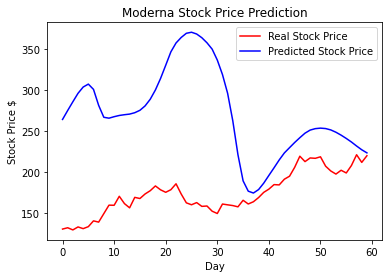

In [409]:
# Visualising the results
plt.plot(real_stock_price[60:120], color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price[:,2], color = 'blue', label = 'Predicted Stock Price')
plt.title('Moderna Stock Price Prediction')
plt.xlabel('Day')
plt.ylabel('Stock Price $')
plt.legend()
plt.show()